In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, List, Dict

In [4]:
class NewsClassifier:
    def __init__(self):
        self.vectorizer = TfidfVectorizer(
            max_features=5000,
            min_df=5,
            max_df=0.7,
            ngram_range=(1, 2),
            stop_words='english'
        )
        self.best_model = None

    def preprocess_data(self, train_df: pd.DataFrame, test_df: pd.DataFrame = None) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Preprocess the text data using TF-IDF vectorization
        """
        # Fit vectorizer on training data
        X_train = self.vectorizer.fit_transform(train_df['Text'])
        y_train = train_df['Category']

        # Transform test data if provided
        X_test = self.vectorizer.transform(test_df['Text']) if test_df is not None else None

        return X_train, y_train, X_test

    def evaluate_decision_tree_criterion(self, X: np.ndarray, y: np.ndarray) -> Tuple[Dict, plt.Figure]:
        """
        Evaluate decision tree performance with different criterion
        """
        results = {}
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

        for criterion in ['gini', 'entropy']:
            dt = DecisionTreeClassifier(criterion=criterion, random_state=42)
            dt.fit(X_train, y_train)

            train_acc = dt.score(X_train, y_train)
            val_acc = dt.score(X_val, y_val)

            results[criterion] = {'train': train_acc, 'val': val_acc}

        # Create bar plot
        fig, ax = plt.subplots(figsize=(10, 6))
        x = np.arange(len(results))
        width = 0.35

        # Create bars
        training_bars = ax.bar(x - width/2, [v['train'] for v in results.values()],
                              width, label='Training')
        validation_bars = ax.bar(x + width/2, [v['val'] for v in results.values()],
                                width, label='Validation')

        # Add accuracy numbers on top of bars
        def autolabel(rects):
            for rect in rects:
                height = rect.get_height()
                ax.annotate(f'{height:.2f}',
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom')

        autolabel(training_bars)
        autolabel(validation_bars)

        ax.set_ylabel('Accuracy')
        ax.set_title('Decision Tree Performance by Criterion')
        ax.set_xticks(x)
        ax.set_xticklabels(results.keys())
        ax.legend()

        return results, fig

    def cross_validate_parameter(self, X: np.ndarray, y: np.ndarray,
                               param_name: str, param_values: List,
                               model_class, base_params: Dict = None) -> Tuple[pd.DataFrame, plt.Figure]:
        """
        Perform cross-validation for a given parameter
        """
        if base_params is None:
            base_params = {}

        results = []
        kf = KFold(n_splits=5, shuffle=True, random_state=42)

        for value in param_values:
            params = {**base_params, param_name: value}
            model = model_class(**params, random_state=42)

            train_scores = []
            val_scores = []

            for train_idx, val_idx in kf.split(X):
                X_train_fold, X_val_fold = X[train_idx], X[val_idx]
                y_train_fold, y_val_fold = y[train_idx], y[val_idx]

                model.fit(X_train_fold, y_train_fold)

                train_scores.append(model.score(X_train_fold, y_train_fold))
                val_scores.append(model.score(X_val_fold, y_val_fold))

            results.append({
                param_name: value,
                'train_mean': np.mean(train_scores),
                'train_std': np.std(train_scores),
                'val_mean': np.mean(val_scores),
                'val_std': np.std(val_scores)
            })

        # Create DataFrame
        results_df = pd.DataFrame(results)

        # Create line plot
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.errorbar(results_df[param_name], results_df['train_mean'],
                   yerr=results_df['train_std'], label='Training')
        ax.errorbar(results_df[param_name], results_df['val_mean'],
                   yerr=results_df['val_std'], label='Validation')

        ax.set_xlabel(param_name)
        ax.set_ylabel('Accuracy')
        ax.set_title(f'Model Performance vs {param_name}')
        ax.legend()

        return results_df, fig

    def train_best_model(self, X: np.ndarray, y: np.ndarray, model_params: Dict) -> None:
        """
        Train the final model with the best parameters
        """
        self.best_model = RandomForestClassifier(**model_params, random_state=42)
        self.best_model.fit(X, y)

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Make predictions using the best model
        """
        if self.best_model is None:
            raise ValueError("Model has not been trained yet")
        return self.best_model.predict(X)

    def save_predictions(self, test_df: pd.DataFrame, predictions: np.ndarray, output_file: str) -> None:
        """
        Save predictions to a CSV file
        """
        results_df = pd.DataFrame({
            'ArticleId': test_df['ArticleId'],
            'Category': predictions
        })
        results_df.to_csv(output_file, index=False, header=False)


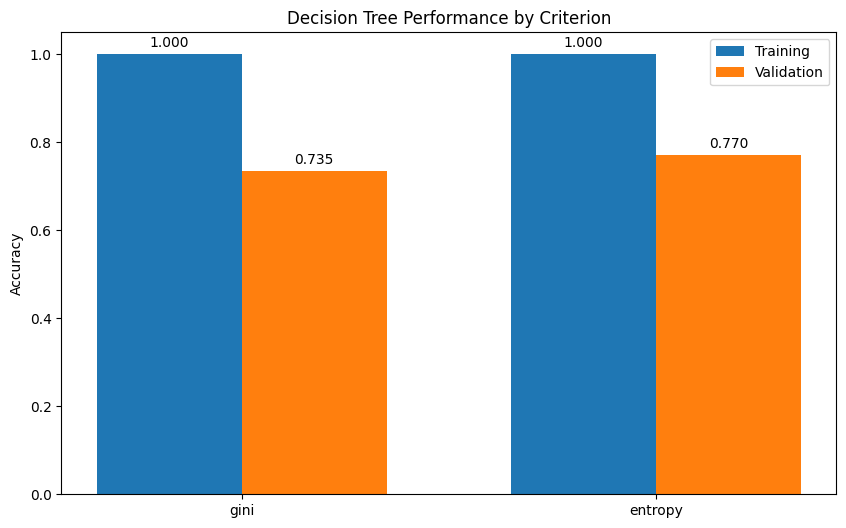

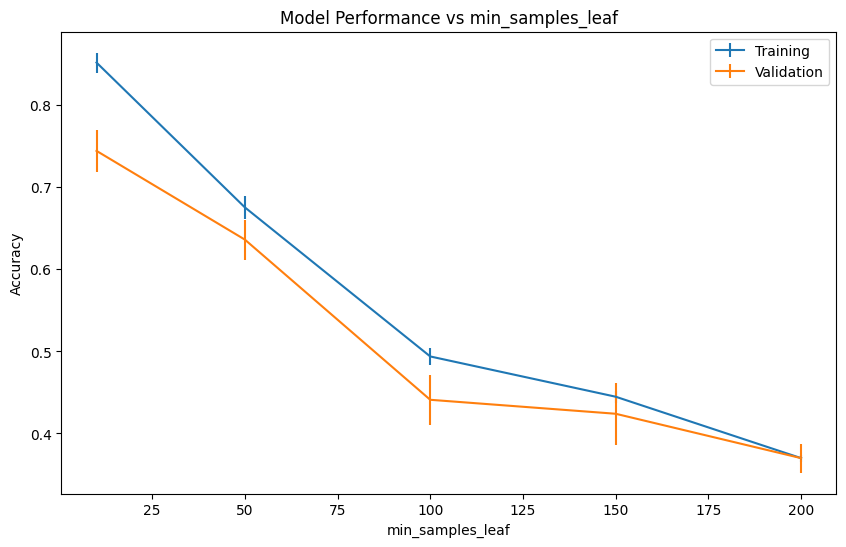

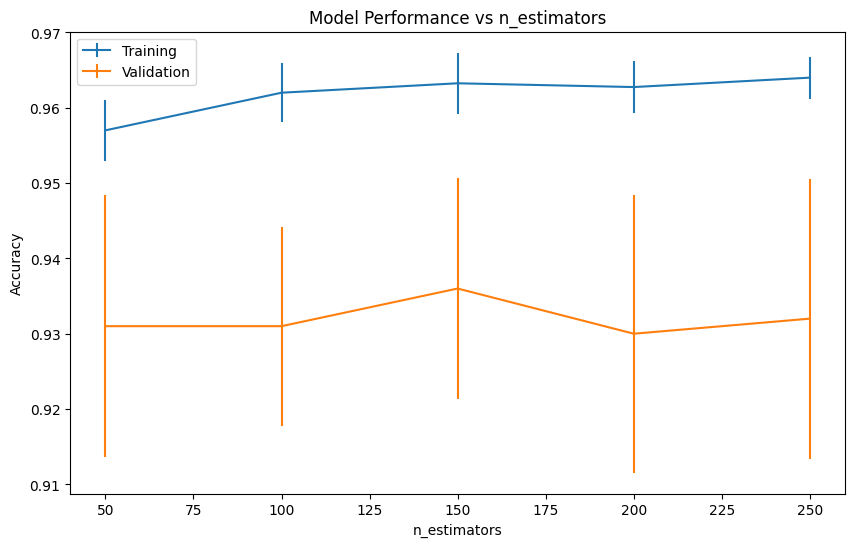

In [6]:
def main():
    # Load data
    train_df = pd.read_csv('24_train_3.csv')
    test_df = pd.read_csv('news-test-1.csv')

    # Initialize classifier
    classifier = NewsClassifier()

    # Preprocess data
    X_train, y_train, X_test = classifier.preprocess_data(train_df, test_df)

    # Evaluate decision tree criterion
    dt_results, dt_fig = classifier.evaluate_decision_tree_criterion(X_train.toarray(), y_train)

    # Cross-validate decision tree parameters
    dt_leaf_values = [10, 50, 100, 150, 200]
    dt_leaf_results, dt_leaf_fig = classifier.cross_validate_parameter(
        X_train.toarray(), y_train,
        'min_samples_leaf', dt_leaf_values,
        DecisionTreeClassifier
    )

    # Cross-validate random forest parameters
    rf_trees_values = [50, 100, 150, 200, 250]
    rf_results, rf_fig = classifier.cross_validate_parameter(
        X_train.toarray(), y_train,
        'n_estimators', rf_trees_values,
        RandomForestClassifier,
        {'min_samples_leaf': 10}  # Example base parameters
    )

    # Train best model (example parameters)
    best_params = {
        'n_estimators': 200,
        'min_samples_leaf': 10,
        'max_features': 'sqrt'
    }
    classifier.train_best_model(X_train, y_train, best_params)

    # Make predictions on test set
    predictions = classifier.predict(X_test)

    # Save predictions
    classifier.save_predictions(test_df, predictions, 'labels.csv')

if __name__ == "__main__":
    main()